In [3]:
import numpy as np
import cvxpy as cp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import datetime as dt

pd.options.display.float_format = '{:,}'.format

In [4]:
%load_ext autoreload
%autoreload 2
from utils_data import PATH_HOME, PATH_DATA, CAISO, NODES
from utils_data import readin_caiso_lmp, make_analysis_dataset
from utils_battery import get_optimal_battery_schedule, get_limited_optimal_battery_schedule
from utils_battery import get_Q_battery_schedule, get_naive_battery_schedule
from utils_plot import set_plt_settings, plot_optimal_performance, plot_optimal_rev_by_duration

PATH_RESULTS = f'{PATH_DATA}results/'
set_plt_settings()

In [8]:
# read in data
data = make_analysis_dataset(nodes=NODES)
data = sm.add_constant(data)

# Get schedule for each node, duration, and strategy

In [17]:
durations = [4, 6, 8, 12, 24, 48, 100]
durations = [4]
y = 2022
capacity = 200
foresight = 10

X_cols, y_col = ['month', 'const', 'quarter', 'hour', 'dow'], 'lmp_rt'
hp_override = [0.1, 0.99, 0.5, 1]

In [18]:
summary = {}
revenues = {}
for node, dur in tqdm(list(itertools.product(*[NODES, durations]))):
    # set data
    p = data.lmp_rt[(data.location == node) & (data.year == y)].to_numpy() # prices are $/MWh 
    time = data.time[(data.location == node) & (data.year == y)].to_numpy()
    
    # get schedules
    __, __, __, revenue_n = get_naive_battery_schedule(p, time, dur, capacity, True)
    __, __, __, revenue_optlim = get_limited_optimal_battery_schedule(foresight, p, dur, capacity, 0, True)
    __, __, __, revenue_opt = get_optimal_battery_schedule(p, dur, capacity, 0, True)
    __, revrew_Q = get_Q_battery_schedule(data.loc[(data.location == node)], X_cols, y_col, 
                                          node, dur, hp_override)
    # save summaries
    summary[(node, f'{dur}hr')] = [revenue_n[-1], revenue_optlim[-1], revenue_opt[-1], revrew_Q[0,:].sum()]
    revenues[(node, dur)] = [revenue_n, revenue_optlim, revenue_opt, np.cumsum(revrew_Q[0,:])]

100%|█████████████████████████████████████████████| 4/4 [02:06<00:00, 31.53s/it]


# Summarize

In [19]:
# summarize
summ_df = pd.DataFrame(summary).T
summ_df.columns = ['naive', f'optimal ({foresight}-day)', 'optimal', 'mf RL']
summ_df = summ_df / 1000000
summ_df['mb RL'] = '-'

print(summ_df.round(1).to_latex())

\begin{tabular}{llrrrrl}
\toprule
               &     &  naive &  optimal (10-day) &  optimal &  mf RL & mb RL \\
\midrule
TH\_NP15\_GEN-APND & 4hr &   12.1 &              25.8 &     25.7 &  -30.3 &     - \\
TH\_SP15\_GEN-APND & 4hr &   16.6 &              29.6 &     29.4 &  -25.8 &     - \\
MOSSLDB\_2\_B1 & 4hr &    9.9 &              28.2 &     28.1 &  -31.2 &     - \\
SANDLOT\_2\_N022 & 4hr &   17.0 &              30.2 &     30.1 &  -25.0 &     - \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_44367/912588432.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summ_df.round(1).to_latex())


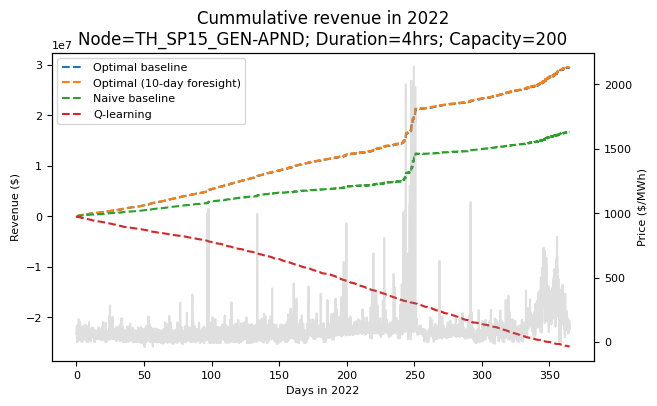

In [20]:
dur = 4
node = NODES[1]
revenue_n, revenue_optlim, revenue_opt, revenue_Q = revenues[(node, dur)]

x = np.arange(len(p))/4/24
fig, axL = plt.subplots(figsize=(7, 4))
axR = axL.twinx()
axL.plot(x, revenue_opt, linestyle='--', label='Optimal baseline')
axL.plot(x, revenue_optlim, linestyle='--', label=f'Optimal ({foresight}-day foresight)')
axL.plot(x[:-1], revenue_n, linestyle='--', label='Naive baseline')
axL.plot(x, revenue_Q, linestyle='--', label='Q-learning')

axR.plot(x, p, alpha=0.25, color='grey')
axL.set_title(f'Cummulative revenue in {y}\nNode={node}; Duration={dur}hrs; Capacity={capacity}')
axL.set_ylabel('Revenue ($)')
axR.set_ylabel('Price ($/MWh)')
axL.set_xlabel(f'Days in {y}')
axL.legend()
plt.savefig(PATH_HOME + '/results/summ4hr.png', bbox_inches='tight')
plt.show()

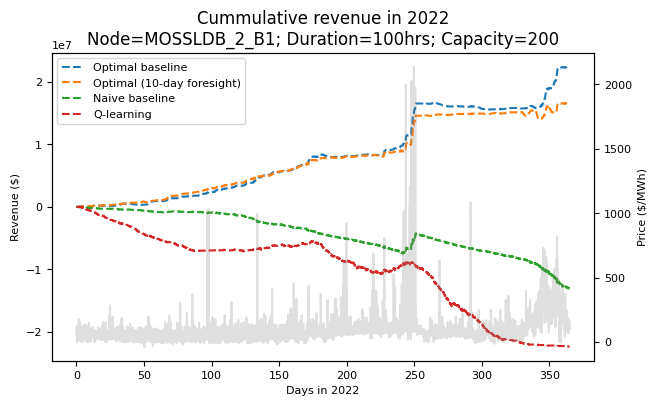

In [38]:
dur = 100
node = NODES[2]
revenue_n, revenue_optlim, revenue_opt, revenue_Q = revenues[(node, dur)]

x = np.arange(len(p))/4/24
fig, axL = plt.subplots(figsize=(7, 4))
axR = axL.twinx()
axL.plot(x, revenue_opt, linestyle='--', label='Optimal baseline')
axL.plot(x, revenue_optlim, linestyle='--', label=f'Optimal ({foresight}-day foresight)')
axL.plot(x[:-1], revenue_n, linestyle='--', label='Naive baseline')
axL.plot(x, revenue_Q, linestyle='--', label='Q-learning')

axR.plot(x, p, alpha=0.25, color='grey')
axL.set_title(f'Cummulative revenue in {y}\nNode={node}; Duration={dur}hrs; Capacity={capacity}')
axL.set_ylabel('Revenue ($)')
axR.set_ylabel('Price ($/MWh)')
axL.set_xlabel(f'Days in {y}')
axL.legend()
plt.savefig(PATH_HOME + '/results/summ100hr.png', bbox_inches='tight')
plt.show()

# First attempt

In [31]:
summ_df1 = summ_df.copy()